# Spatial Regression Discontinuity Design: India

## Background

The long-term effects of colonization have been an oft-discussed topic in the field of developmental economics. In her paper titled "[Direct Versus Indirect Colonial Rule in India: Long-term Consequences](https://www.hbs.edu/ris/Publication%20Files/05-041_1feff996-f50e-4e5a-b057-e0119cd19a62.pdf)", Lakshimi Iyer researches this issue within the context of British rule over India. 

During the time of the British Raj, Britain had control over the entirity of India; however, they implemented two types of governance within the region. British provinces were regions that were directly administered by the British. In these areas, the local ruler was overthrown, and a British minister was put in control of the government. The remaining areas of India were called the princely states. Princely states were regions of India where the local ruler signed a treaty of vassalage to the British government. These regions were not completely independent; however, the local ruler still governed the region. This privilege offered the local ruler some autonomy when it came to internal affairs. 

The image below shows the British provinces and the princely states at the time of the 1941 Census of India, the last census before Indian independence. British provinces are shown in pink while the native states are in yellow. British provinces constituted approximately 55% of India, and princely states made up the remaining 45%.


<img src='historicalmap_small.jpg'>

In Iyer's paper, she compared the differences between modern-day Indian districts that are located in the former British provinces and districts that are located in the former princely states. The former I will call British districts and the latter princely districts. Her hypothesis stated that the local rulers were likely less exploitive of the region than the British governors were. Thus, the princely states would have had better governance and more investment within the region during colonial times. This contrast in colonial governance may have led to long-term differences between the two types of districts that still exist today.

To test this hypothesis, Iyer made use of an Instrumental Variable model. Her results showed that the British districts have less public goods today than the princely districts. In particular, the British districts have less schools and health centers. Furthermore, the people in the British districts today have less economic well-being than their princely district counterparts.  

My goal with this project is to study the same problem as Iyer. However, I want to approach the problem with a different method. I still want to test the long-term effects of colonization by comparing the former British province areas with the princely state areas. However, instead of an Instrumental Variable model, I want to make use of a Spatial Regression Discontinuity Design (Spatial RDD).


The basic idea of Spatial RDD is to compare two areas that are geographically near to one another but are located on different sides of some treatment border. Since the areas are located so close to one another, they should be alike in almost every way. The only difference between them should be the treatment effect which changes when crossing the border.

The concept is easier to explain when relating it to this project. In India, many of the historical borders between the former British provinces and princely states have become the modern-day borders between districts. My idea is to examine the regions near these modern district borders which were once the historical borders between British province and princely state. The region very close to one side of a border should be no different to region directly across the border. Since they live so near to one another, the people should have very similar demographic characteristics like religion and language. The environmental characteristics of the regions like elevation and vegetation should also be the same.

There should only be one major difference between the regions on differing sides of the border. One region is located in a former British province and the other region is located in a former princely state. This is my treatment effect. Everything else between the two regions should be the same. Thus, if I find any significant differences in public goods or economic well-being in the areas which are very close to but on different sides of a treatment border, it can be attributed to the treatment effect. It would provide evidence that being a British province or a princely state did have long-term effects on an area. Places located right next to one another, which are similar in every way except being a former British province or princely state, are different today because of it.

<img src='andhra_map.jpg'>


The map above shows the Indian state of Andhra Pradesh in 2001. The map has divided the state at the subdistrict level, which is the administrative division directly below district. The red line denotes a treatment border that I created. Again, this designates a historical border between British provinces and princely states that is still being used today as a border between Indian districts. The pink areas are subdistricts which were in a British province, and the yellow designates those in a princely state. The slightly transparent blue region denotes lands that are within 50km of the treatment border. Only subdistricts located within this blue region will be used in my Spatial RDD.

## Data Collection

Some creativity is needed in order to create variables for economic well-being. It would be ideal to use per capita income or something similar; however, this data is not available at the subdistrict level, which is the level needed for my Spatial RDD. The Census of India does provide data on households at the subdistrict level. Using this household data, I have created a set of living standard variables, which proxy for economic well-being. These living standard variables are a combination of asset ownership like owning a car and household characteristics like having electricity. Obviously, the assumption is that areas where people have lower living standards suffer from greater poverty.

In [1]:
import os
import numpy as np
import pandas as pd

os.chdir('C:\\Users\\StuartWilson\\Documents\Portfolio\India')
pd.options.mode.chained_assignment = None

states = ['AndhraPradesh', 'Chhattisgarh', 'Gujarat',
          'Karnataka', 'Kerala', 'MadhyaPradesh', 
          'Maharashtra', 'Punjab', 'Orissa',
          'Uttarakhand']

for state in states:
    filenames = ['HHAssets', 'Bathroom', 'DrinkingWater', 'Lighting',
                 'FloorMaterial', 'Religion', 'MotherTongue']
    dataframes = []
    for file in filenames:
        if file == 'Bathroom':
            df = pd.read_excel('Census\\' + state + '\\' + file + '.xls')
            cols = df.iloc[1:5, :].fillna('')
            df.columns = (cols.iloc[0, :] + cols.iloc[1, :]
                          + cols.iloc[2, :] + cols.iloc[3, :]).str.strip()
            df = df.iloc[6:]
        elif file in ['DrinkingWater', 'FloorMaterial', 'Religion', 'Lighting']:
            df = pd.read_excel('Census\\' + state + '\\' + file + '.xls')
            cols = df.iloc[0:3, :].fillna('')
            df.columns = (cols.iloc[0, :] + cols.iloc[1, :] + cols.iloc[2, :]).str.strip()
            if file == 'Religion':
                df = df.iloc[6:]
            else:
                df = df.iloc[4:]
        else:
            df = pd.read_excel('Census\\' + state + '\\' + file + '.xls')
            cols = df.iloc[1:4, :].fillna('').astype('str')
            df.columns = (cols.iloc[0, :] + cols.iloc[1, :] + cols.iloc[2, :]).str.strip()
            df = df.iloc[5:, :]
        df = df.iloc[:, 1:]
        df = df.rename(columns={'STATE': 'StateCode',
                                'DISTRICT': 'DistrictCode',
                                'Distt.Code': 'DistrictCode',
                                'TEHSIL': 'TehsilCode',
                                'Tehsil/CityCode': 'TehsilCode',
                                'Tehsil/TownCode': 'TehsilCode',
                                'Total number of households': 'TotalHouseholds',
                                'Availability of assetsRadio, Transistor': 'Radio',
                                'Car, Jeep, Van': 'Car',
                        'Number ofhouseholds having bathroom facility within the house': 'Bathroom',
                                'Water closet': 'FlushToilet',
                                'Source of drinking waterTap': 'TapWater',
                                'Source of lightingElectricity': 'Electricity',
                                'Material of floorMud': 'MudFloor',
                                'Religious communitiesHinduPersons': 'Hindus',
                                'MOTHERTONGUECODE': 'MotherTongueCode',
                                'MOTHER TONGUE1': 'MotherTongue',
                                'TOTALP2': 'HindiSpeakers',
                                'Total number of censushouses': 'TotalHouseholds_Floor'})

        df['Code'] = df['StateCode'] + df['DistrictCode'] + df['TehsilCode']

        if file == 'DrinkingWater':
            df = df.loc[(df['Location'] == 'Total') &
                        (df['Total/Rural/Urban'] == 'Total')]
        elif file == 'MotherTongue':
            df = df.loc[df['MotherTongueCode'] == '006000']
        else:
            df = df.loc[df['Total/Rural/Urban'] == 'Total']

        if file == 'HHAssets':
            df['Code_StateDist'] = df['StateCode'] + df['DistrictCode']

            district = df.copy()
            district = district.loc[(district['DistrictCode'] != '00') &
                                    (district['TehsilCode'] == '0000')].copy()
            district_name = district['Area Name'].str.split('-').str[1]
            district['District'] = district_name.replace('[^a-zA-Z ]', '', regex=True).str.strip()
            district['State'] = state
            district = district[['District', 'State', 'Code_StateDist']]
            dataframes.append(district)

        df = df.loc[df['TehsilCode'] != '0000']

        dataframes.append(df)

    district = dataframes[0]
    hh = dataframes[1].drop(['Total/Rural/Urban', 'Total number ofhouseholds availingbanking services',
                             'Telephone', 'Bicycle', 'Scooter, MotorCycle, Moped',
                             'None of thespecified assets'], axis=1)
    bathroom = dataframes[2][['Code', 'Bathroom', 'FlushToilet']]
    water = dataframes[3][['Code', 'TapWater']]
    lighting = dataframes[4][['Code', 'Electricity']]
    floor = dataframes[5][['Code', 'MudFloor', 'TotalHouseholds_Floor']]
    religion = dataframes[6][['Code', 'TotalPersons', 'Hindus']]
    religion.loc[:, 'TotalPersons'] = religion.loc[:, 'TotalPersons'].astype('float')
    mothertongue = dataframes[7][['Code', 'HindiSpeakers']]

    df = district
    df = df.merge(hh, on='Code_StateDist')

    census_var = [bathroom, water, lighting,
                  floor, religion, mothertongue]
    for ele in census_var:
        df = df.merge(ele, on='Code', how='outer')
    df = df.dropna(subset=['Hindus'])

    if state == 'AndhraPradesh':
        census_data = df
    else:
        census_data = pd.concat([census_data, df])
census_data = census_data.reset_index().drop('index', axis=1)
census_data['HindiSpeakers'] = census_data['HindiSpeakers'].fillna(0)

census_data.loc[census_data['Code'] == '29050004', 'TotalPersons'] = 174257
census_data.loc[census_data['Code'] == '29050004', 'Hindus'] = 83532

census_data.head()

,District,State,Code_StateDist,StateCode,DistrictCode,TehsilCode,Area Name,TotalHouseholds,Radio,Television,...,Code,Bathroom,FlushToilet,TapWater,Electricity,MudFloor,TotalHouseholds_Floor,TotalPersons,Hindus,HindiSpeakers
0,Adilabad,AndhraPradesh,2801,28,01,0001,Mandal - Tamsi 0001,7490,1117,982,...,28010001,1811,219,1158,3430,7473,10549,36164.0,33774,807
1,Adilabad,AndhraPradesh,2801,28,01,0002,Mandal - Adilabad 0002,31889,5304,13116,...,28010002,16780,6836,7643,21391,14655,39110,170090.0,122257,8921
2,Adilabad,AndhraPradesh,2801,28,01,0003,Mandal - Jainad 0003,9538,1075,1267,...,28010003,2024,123,1516,4435,6658,12735,44805.0,42494,618
3,Adilabad,AndhraPradesh,2801,28,01,0004,Mandal - Bela 0004,6367,822,614,...,28010004,586,86,569,1934,6503,8951,32970.0,30915,2117
4,Adilabad,AndhraPradesh,2801,28,01,0005,Mandal - Talamadugu 0005,6592,813,915,...,28010005,1218,106,1142,4181,6916,9229,31103.0,29642,750


For all my living standard variables, I normalize them by dividing the raw data by the total number of households in each subdistrict.

In [2]:
livelihood = ['Radio', 'Television', 'Car', 'Bathroom', 'FlushToilet', 'TapWater', 'Electricity',
              'MudFloor']

for var in livelihood:
    if var == 'MudFloor':
        census_data[var + '_Prop'] = census_data[var] / census_data['TotalHouseholds_Floor']
    else:
        census_data[var + '_Prop'] = census_data[var] / census_data['TotalHouseholds']

livelihood_prop = census_data[['Area Name', 'Radio_Prop', 'Television_Prop', 'Car_Prop', 'Bathroom_Prop', 
                               'FlushToilet_Prop', 'TapWater_Prop', 'Electricity_Prop', 'MudFloor_Prop']]
livelihood_prop.head()

,Area Name,Radio_Prop,Television_Prop,Car_Prop,Bathroom_Prop,FlushToilet_Prop,TapWater_Prop,Electricity_Prop,MudFloor_Prop
0,Mandal - Tamsi 0001,0.149132,0.131108,0.001335,0.241789,0.029239,0.154606,0.457944,0.708408
1,Mandal - Adilabad 0002,0.166327,0.411302,0.015334,0.5262,0.214369,0.239675,0.670796,0.374712
2,Mandal - Jainad 0003,0.112707,0.132837,0.00325,0.212204,0.012896,0.158943,0.464982,0.522811
3,Mandal - Bela 0004,0.129103,0.096435,0.003298,0.092037,0.013507,0.089367,0.303754,0.726511
4,Mandal - Talamadugu 0005,0.123331,0.138805,0.003489,0.184769,0.01608,0.17324,0.634254,0.749377


My final variables for living standards are proportions of households with a radio, a television, a car, a bathroom, a flush toilet, tap water, electricity, and a mud floor.


For the public goods data, I made use of the [India Village-Level Geospatial Socioeconomic Data Set](https://sedac.ciesin.columbia.edu/data/set/india-india-village-level-geospatial-socio-econ-1991-2001). This data set includes over 200 socio-economic variables, calculated at the village/town level. Many of these variables are related to public goods like schools and hospitals.

This data is distributed as a Geographic Information System (GIS) shapefile; therefore, I use ArcGIS to prep this data. The image below describes how I make this data usable in Python. Essentially, I aggregrate the data from the village/town level to the subdistrict level. Then, I convert the data from shapefiles to CSV files. In this pipeline, I also calculate the area of each subdistrict in square kilometers.

<img src='Tehsil_model_capt.jpg'>

The below code shows these ArcGIS steps implemented with ArcPy, a Python package that allows one to perform the geographic processes of ArcGIS within Python.

In [ ]:
import arcpy
import os
import pandas as pd

os.chdir('C:\\Users\\StuartWilson\\Documents\\Portfolio\\India')
arcpy.env.workspace = 'C:\\Users\\StuartWilson\\Documents\\Portfolio\\India'
arcpy.env.overwriteOutput = True

states = ['AndhraPradesh', 'Chhattisgarh', 'Gujarat',
          'Haryana', 'HimachalPradesh', 'Karnataka',
          'Kerala', 'MadhyaPradesh', 'Maharashtra',
          'Orissa', 'Punjab', 'TamilNadu',
          'Uttarakhand', 'UttarPradesh']

#Clean village data 
for state in states:
    village_shp = "Village\\"+state+"\\village.shp"
    copy_shp = "Temp\\copy_"+state+".shp"

    # Process: Copy Features
    arcpy.CopyFeatures_management(village_shp, copy_shp, "", "0", "0", "0")
    # Process: Add Field
    arcpy.AddField_management(copy_shp, "key", "TEXT", "", "", "", "", "NULLABLE", "NON_REQUIRED", "")
    # Process: Calculate Field
    arcpy.CalculateField_management(copy_shp, "key", "str(!C_CODE01!) + str(!NAME!)", "PYTHON_9.3",
                                    "")
    # Process: Delete Field
    arcpy.DeleteField_management(copy_shp, "VILL_NAME;NEAR_TOWN")

    village_edit_csv = village_shp
    Temp = "Temp"
    # Process: Table to Table
    arcpy.TableToTable_conversion(copy_shp, Temp, "village_edit_"+state+".csv", "")

    df = pd.read_csv('Temp\\village_edit_'+state+'.csv',
                     dtype = {'TID' : 'object',
                              'VILL_CODE' : 'object',
                              'C_CODE01' : 'object'})
    df.iloc[:, 18:-1] = df.iloc[:, 18:-1].fillna(0)

    def to_number(x):
        if type(x) != str:
            return x
        else:
            if x.isdigit() == True:
                return int(x)
            else:
                return 0

    variables = ['No_HH', 'TOT_P', 'P_SC', 'P_ST', 'TOT_WORK_P', 'MAINWORK_P',
                 'MAIN_CL_P', 'MAIN_AL_P', 'MARGWORK_P', 'MARG_CL_P',
                 'MARG_AL_P', 'T_P', 'SC_P', 'ST_P', 'P_SCH',
                 'M_SCH', 'S_SCH', 'S_S_SCH', 'PH_CNTR', 'POST_OFF',
                 'PHONE', 'AREA', 'T_HH', 'key']
    df = df[variables]
    for ele in variables:
        if ele == 'key':
            continue
        else:
            df[ele] = df[ele].apply(to_number)

    export = df.to_csv('Temp\\village_csv_'+state+'.csv')

    village_csv_csv = "Temp\\village_csv_"+state+".csv"
    # Process: Table to Table (2)
    arcpy.TableToTable_conversion(village_csv_csv, Temp, "village_dbf_"+state+".dbf", "")
    village_dbf_dbf = "Temp\\village_dbf_"+state+".dbf"
    # Process: Delete Field (2)
    arcpy.DeleteField_management(copy_shp,
                                 "No_HH;TOT_P;P_SC;P_ST;TOT_WORK_P;MAINWORK_P;MAIN_CL_P;MAIN_AL_P;MARGWORK_P;MARG_CL_P;MARG_AL_P;AREA;T_HH;T_P;SC_P;ST_P;P_SCH;M_SCH;S_SCH;S_S_SCH;PH_CNTR;POST_OFF;PHONE")
    # Process: Join Field
    arcpy.JoinField_management(copy_shp, "key", village_dbf_dbf, "key",
                               "No_HH;TOT_P;P_SC;P_ST;TOT_WORK_P;MAINWORK_P;MAIN_CL_P;MAIN_AL_P;MARGWORK_P;MARG_CL_P;MARG_AL_P;AREA;T_HH;T_P;SC_P;ST_P;P_SCH;M_SCH;S_SCH;S_S_SCH;PH_CNTR;POST_OFF;PHONE")
    village_prep_shp = "Village\\"+state+"\\village_prep.shp"
    # Process: Copy Features (2)
    arcpy.CopyFeatures_management(copy_shp, village_prep_shp, "", "0", "0", "0")

#Aggregate village data to subdistrict level
for state in states:
    print(state)

    village_prep_shp = "Village\\"+state+"\\village_prep.shp"
    copy_shp = "Temp\\copy_"+state+".shp"
    tehsil_shp = "Tehsil\\"+state+"\\tehsil.shp"
    Tehsil = "Tehsil\\"+state

    # Process: Copy Features
    arcpy.CopyFeatures_management(village_prep_shp, copy_shp, "", "0", "0", "0")
    # Process: Add Field
    arcpy.AddField_management(copy_shp, "Code", "TEXT", "", "", "", "", "NULLABLE", "NON_REQUIRED", "")
    # Process: Calculate Field
    arcpy.CalculateField_management(copy_shp, "code", "str(!SID!) + str(!DID!) + str(!TID!) ",
                                    "PYTHON_9.3", "")
    # Process: Dissolve
    arcpy.Dissolve_management(copy_shp, tehsil_shp, "Code",
                              "No_HH SUM;TOT_P SUM;P_SC SUM;P_ST SUM;TOT_WORK_P SUM;MAINWORK_P SUM;MAIN_CL_P SUM;MAIN_AL_P SUM;MARGWORK_P SUM;MARG_CL_P SUM;MARG_AL_P SUM;T_P SUM;SC_P SUM;ST_P SUM;P_SCH SUM;M_SCH SUM;S_SCH SUM;S_S_SCH SUM;PH_CNTR SUM;POST_OFF SUM;PHONE SUM",
                              "MULTI_PART", "DISSOLVE_LINES")
    # Process: Table to Table
    arcpy.TableToTable_conversion(tehsil_shp, Tehsil, "tehsil.csv")




After turning these shapefiles into CSV files, I am able to obtain the data on public goods. Again, I normalize this data; however, this time I normalize it by population (per 10,000) and not by total households. My variables for public goods are primary schools (elementary schools), middle schools, secondary schools, primary health centers, post offices, and telephone connections per 10,000 people.

In [3]:
for state in states:
    tehsil = pd.read_csv('Tehsil\\' + state + '\\tehsil.csv',
                         dtype={'Code': 'object'})
    tehsil = tehsil.drop('OID', axis=1)
    tehsil = tehsil.rename(columns={'SUM_P_SCH': 'PrimarySchool',
                                    'SUM_M_SCH': 'MiddleSchool',
                                    'SUM_S_SCH': 'SecondarySchool',
                                    'SUM_PH_CNT': 'PrimaryHealthCenter',
                                    'SUM_POST_O': 'PostOffice',
                                    'SUM_PHONE': 'Phone',
                                    'SUM_No_HH': 'TotalHH'})
    
    if state == 'AndhraPradesh':
        tehsil_merge = tehsil
    else:
        tehsil_merge = pd.concat([tehsil_merge, tehsil])

    area = pd.read_csv('Temp\\' + state + '_area.csv',
                       usecols=['Code', 'area_km'],
                       dtype={'Code': 'object'})
    if state == 'AndhraPradesh':
        area_all = area
    else:
        area_all = pd.concat([area_all, area])

census_data = census_data.merge(tehsil_merge, on='Code')
census_data = census_data.loc[census_data['SUM_T_P'] != 0]
census_data = census_data.merge(area_all, on='Code')

public_goods = ['PrimarySchool', 'MiddleSchool', 'SecondarySchool',
                'PrimaryHealthCenter', 'PostOffice', 'Phone']

for var in public_goods:
    census_data[var + '_Prop'] = (census_data[var] / census_data['TotalPersons']) * 10000

public_goods_prop = census_data[['Area Name', 'PrimarySchool_Prop', 'MiddleSchool_Prop',
                                 'SecondarySchool_Prop','PrimaryHealthCenter_Prop','PostOffice_Prop',
                                 'Phone_Prop']]
public_goods_prop.head()

,Area Name,PrimarySchool_Prop,MiddleSchool_Prop,SecondarySchool_Prop,PrimaryHealthCenter_Prop,PostOffice_Prop,Phone_Prop
0,Mandal - Tamsi 0001,16.867603,2.212145,1.106072,0.553036,2.212145,3.041699
1,Mandal - Adilabad 0002,5.173732,0.940678,0.411547,0.058792,0.940678,4.997354
2,Mandal - Jainad 0003,13.168173,2.901462,1.115947,0.223189,3.124651,22.095748
3,Mandal - Bela 0004,28.814073,3.033060,1.516530,0.303306,1.819836,23.051259
4,Mandal - Talamadugu 0005,15.111083,3.536636,1.929074,0.321512,3.858149,2.250587


To distinguish between subdistricts that were British provinces during colonial rule from those that were princely states, I use a dummy variable. The variable equals 1 if the subdistrict was formerly a British province and 0 otherwise. Iyer provides replication data for her paper. She labels each modern district as either a British province or a princely state. I simply used this data and assigned the value accordingly for each subdistrict.

Iyer's replication data also contains information on which specific British province or princely state the district was a part of. I have included this data as well.

In [4]:
iyer = pd.read_csv('Replication/dist_brit.csv')
iyer = iyer[['state', 'dist_91',
             'britdum', 'kcode1', 'kname1']].rename(columns={'state': 'iyer_state',
                                                             'dist_91': 'Iyer',
                                                             'kname1': 'Kingdom'})
iyer.loc[447] = ['Orissa', 'Nuapada', 1, 1032, 'Sambalpur']
iyer.loc[iyer['Iyer'] == 'Chamoli', 'britdum'] = 1
iyer.loc[iyer['Iyer'] == 'Balangir', 'britdum'] = 0
iyer = iyer.loc[iyer['iyer_state'].isin(['Andhra Pradesh', 'Chhattisgarh',
                                         'Gujarat', 'Haryana',
                                         'Himachal Pradesh', 'Karnataka',
                                         'Kerala', 'Madhya Pradesh',
                                         'Maharashtra', 'Orissa',
                                         'Punjab', 'Tamil Nadu',
                                         'Uttarakhand', 'Uttar Pradesh'])]
key = pd.read_excel('Replication\\key.xls', usecols=[0, 3, 4],
                    dtype={'Code_StateDist': 'str'})
key = key.merge(iyer, on='Iyer')
key = key[['Code_StateDist', 'britdum', 'kcode1', 'Kingdom']]

census_data = census_data.merge(key, on='Code_StateDist')

brit = census_data[['Area Name', 'britdum', 'Kingdom']]
brit.head()

C:\Users\StuartWilson\AppData\Local\Programs\Python\Python38\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,Area Name,britdum,Kingdom
0,Mandal - Tamsi 0001,0,Hyderabad
1,Mandal - Adilabad 0002,0,Hyderabad
2,Mandal - Jainad 0003,0,Hyderabad
3,Mandal - Bela 0004,0,Hyderabad
4,Mandal - Talamadugu 0005,0,Hyderabad


I now need to create my treatment borders. Again, these are modern-day borders between Indian districts that also served as the historical borders between British provinces and princely states. The map below shows the treatment borders that I have created. These were created manually within ArcGIS. Each color on the map represents a different Indian state, and the bold lines are the treatment borders. Each treatment border is entirely located within a single state. I do not want to compare areas that are located in different states. Any long-term differences could then be attributed to differences in state administations and governments. I have also tried to create treatment borders that are well-distributed throughout the entirety of India. This helps ensure that I have a good sample which represents the country of India well.

<img src='treatment_borders.jpg'>


While the map of the borders shows the districts of India, it is important to remember that I will be using data at the subdistrict level for my actual analysis. Since subdistricts are located within districts, the borders between neighboring districts will be the same as the borders between neighboring subdistricts. I did not want to use district-level data since districts are too large for this spatial RDD. To create a spatial RDD model, I need to choose a bandwidth around the treatment borders. The bandwidth is the distance from the treatment borders in which observations will be included in the model. The bandwidth should not be too big because you want the regions being compared to be very geoghaphically close to one another. However, the bandwidth has to be big enough to provide a sufficient number of observations. At a useful bandwidth, many districts would simply not fit, and the bandwidth would have to be extended. However, subdistricts do fit. 

After creating the treatment borders, I filter my data in order to only keep the subdistricts that fall within the bandwidth. I have chosen a bandwidth of 50km for this project. For each subdistrit, I measure the distance in meters to its closest treatment border. As the image and the ArcPy code below show, this is done with ArcGIS. 

During this process, I also calculate the longitude and latitude of the centroid for each subdistrict. This will be used later when creating my model.


<img src='near_model_capt.jpg'>

In [ ]:
for state in states:
    state_near_shp = "Temp\\"+state+"_near.shp"
    tehsil_with_brit_shp = "Tehsil\\"+state+"\\tehsil_with_brit.shp"
    state_pt_shp = "Temp\\"+state+"_pt.shp"
    # Process: Feature To Point
    arcpy.FeatureToPoint_management(tehsil_with_brit_shp, state_pt_shp, "CENTROID")
    # Process: Near (2)
    arcpy.Near_analysis(state_pt_shp, "Border\\Merged_split.shp", "", "NO_LOCATION", "NO_ANGLE", "PLANAR")
    # Process: Table to Table (2)
    arcpy.TableToTable_conversion(state_pt_shp, Temp, state+"_near.csv", "",
                                  "",
                                  "")

After calculating each subdistrict's distance to a treatment border, it is simple to filter the data. I merely keep the data that has a value less than or equal to 50,000 meters in this new distance column.

When creating my treatment borders, I separated the borders into several 150-mile segments. The "Border" column below shows which segment each subdistrict is closest to.

In [5]:
for state in states:     
    near = pd.read_csv('Temp\\' + state + '_near.csv',
                        usecols=['Code', 'NEAR_FID', 'NEAR_DIST'],
                        dtype={'Code': 'object', 'NEAR_FID':'object'})
    near = near.rename(columns={'NEAR_DIST':'Distance'})
    near['st'] = state
    near['Border'] = near['st'] + near['NEAR_FID']
    near = near[['Code', 'Border', 'Distance']]
    if state == 'AndhraPradesh':
        near_all = near
    else:
        near_all = pd.concat([near_all, near])

    coord = pd.read_csv('GeoData\\Coordinates\\' + state + '.csv',
                        usecols=['Code', 'POINT_X', 'POINT_Y'],
                        dtype={'Code': 'object'})

    if state == 'AndhraPradesh':
        coord_all = coord
    else:
        coord_all = pd.concat([coord_all, coord])

census_data = census_data.merge(near_all, on='Code')
census_data = census_data.merge(coord_all, on='Code')

rdd_data = census_data.loc[census_data['Distance'] <=50000]

distance = rdd_data[['Area Name', 'Distance', 'Border']]
distance.head()

,Area Name,Distance,Border
251,Mandal - Amrabad 0030,10150.617612,AndhraPradesh0
252,Mandal - Achampet 0031,30665.284699,AndhraPradesh0
253,Mandal - Uppununthala 0032,43572.620589,AndhraPradesh0
254,Mandal - Telkapalle 0033,38462.499101,AndhraPradesh0
256,Mandal - Nagarkurnool 0035,43360.450621,AndhraPradesh0


I am left with 859 subdistricts which fall within 50km of a treatment border. 

In [6]:
print('Shape of dataframe: ' + str(rdd_data.shape))

Shape of dataframe: (859, 65)


## Assumption for Spatial RDD

In order to properly use a spatial RDD, one critical identifying assumption needs to hold. There is an assumption of continuity of observable variables across the treatment border. All relevant factors besides the treatment must vary smoothly at the border. This means that the areas on the opposite sides of the border should be similar in all ways except the treatment. If there are any major differences between the characteristics of the two regions, it is not possible to attribute a difference in outcomes to the actual treatment. For example, imagine one area has greater vegetation than the area across the border. Since this area has greater vegetation, this area will likely have higher agricultural output than the other area. Higher agricultural output could lead to higher incomes and higher economic well-being for this area, compared to the area across the border. Thus, any differences between the areas that my model picks up could be due to this difference in vegetation and not their colonial history as a British province or princely state.

Intuitively, this assumption should hold. A subdistrict on one side of the border should not have any significant environmental differences to a subdistrict right across the border since they are so near to one another. Furthermore, people living near to one another usually have similar demographic characterstics. To try to justify this assumption more empirically, I compare environmental and demographic characteritics across the border. The environmental characterstics are elevation (meters), slope, rainfall (millimeters), and vegetation (measured by NDVI). The demographic characteristics are population (logarithmic), proportion of working population working in agriculture, Scheduled Caste/Tribe proportion, Hindu proportion, and Hindi-speaking proportion. 

Since the demographic data comes from the Indian census and the village-level dataset, I actually already gathered it in the above code blocks. I now need to turn the raw values into proportions.

In [7]:
rdd_data['log_pop'] = np.log(rdd_data['TotalPersons'])
rdd_data['pop_dens'] = rdd_data['TotalPersons'] / rdd_data['area_km']
rdd_data['log_pop_dens'] = np.log(rdd_data['pop_dens'])
rdd_data['total_worker'] = rdd_data['SUM_MAINWO'] + rdd_data['SUM_MARGWO']
rdd_data['agr_worker'] = (rdd_data['SUM_MAIN_C'] + rdd_data['SUM_MAIN_A']
                             + rdd_data['SUM_MARG_C'] + rdd_data['SUM_MARG_A'])
rdd_data['agr_worker_prop'] = rdd_data['agr_worker'] / rdd_data['total_worker']
rdd_data['ST_SC_tot'] = rdd_data['SUM_ST_P'] + rdd_data['SUM_SC_P']
rdd_data['ST_SC_prop'] = rdd_data['ST_SC_tot'] / rdd_data['TotalPersons']
rdd_data['ST_prop'] = rdd_data['SUM_ST_P'] / rdd_data['TotalPersons']
rdd_data['SC_prop'] = rdd_data['SUM_SC_P'] / rdd_data['TotalPersons']
rdd_data['Hindus_prop'] = rdd_data['Hindus'] / rdd_data['TotalPersons']
rdd_data['Hindis_prop'] = rdd_data['HindiSpeakers'] / rdd_data['TotalPersons']

For the geographic data, I obtain satellite data in raster form. The images below show the raster data for elevation, vegetation, and rainfall. The slope data is generated from the elevation raster. Slope refers to the steepness of the land.

Using ArcGIS, I esentially lay these rasters on top of the subdistrict shapefiles. ArcGIS calculates the mean value for each environmental variable in each subdistrict. 

<img src='alldata.jpg'>

<img src='model_geo_capt.jpg'>

In [ ]:
for state in states:
    #Vegetation
    state_dbf = "GeoData\\NDVI\\"+state+".dbf"
    NDVI = "GeoData\\NDVI"
    proj_ndvi_tif = "GeoData\\NDVI\\proj_ndvi.tif"
    # Process: Zonal Statistics as Table
    arcpy.gp.ZonalStatisticsAsTable_sa(tehsil_with_brit_shp, "Code", proj_ndvi_tif, state_dbf,"DATA",
                                       "ALL")
    # Process: Table to Table (2)
    arcpy.TableToTable_conversion(state_dbf, NDVI, state+".csv", "","","")
    proj_elev_tif = "GeoData\\Elev\\proj_elev.tif"
    
    #Elevation
    state_dbf= "GeoData\\Elev\\"+state+".dbf"
    Elev = "GeoData\\Elev"
    # Process: Zonal Statistics as Table (2)
    arcpy.gp.ZonalStatisticsAsTable_sa(tehsil_with_brit_shp, "Code", proj_elev_tif, state_dbf, "DATA", "ALL")
    # Process: Table to Table (3)
    arcpy.TableToTable_conversion(state_dbf, Elev, state+".csv", "", "", "")
    slope_tif = "GeoData\\Slope\\slope.tif"
    
    
    #Steepness
    state_dbf = "GeoData\\Slope\\"+state+".dbf"
    Slope = "GeoData\\Slope"
    # Process: Zonal Statistics as Table (3)
    arcpy.gp.ZonalStatisticsAsTable_sa(tehsil_with_brit_shp, "Code", slope_tif, state_dbf, "DATA",
                                       "ALL")
    # Process: Table to Table (4)
    arcpy.TableToTable_conversion(state_dbf, Slope, state+".csv", "","","")

    #Rainfall
    rain_clip_proj_tif = "GeoData\\Rain\\rain_clip_proj.tif"
    state_dbf = "GeoData\\Rain\\"+state+".dbf"
    Rain = "GeoData\\Rain"
    # Process: Zonal Statistics as Table (4)
    arcpy.gp.ZonalStatisticsAsTable_sa(tehsil_with_brit_shp, "Code", rain_clip_proj_tif, state_dbf, "DATA", "ALL")
    # Process: Table to Table (5)
    arcpy.TableToTable_conversion(state_dbf, Rain, state+".csv", "", "", "")

In [8]:
geos = ['NDVI', 'Elev', 'Slope', 'Rain']
for state in states:
    for geo in geos:
        df = pd.read_csv('GeoData\\' + geo + '\\' + state + '.csv',
                            usecols=['Code', 'MEAN'],
                            dtype={'Code': 'object'})
        df = df.rename(columns={'MEAN': geo})

        if geo == 'NDVI':
            geo_all = df
        else:
            geo_all = geo_all.merge(df, on='Code')
    if state == 'AndhraPradesh':
        geo_final = geo_all
    else:
        geo_final = pd.concat([geo_final, geo_all])

rdd_data = rdd_data.merge(geo_final, on='Code')
rdd_data['NDVI'] = rdd_data['NDVI'] * 0.0001

geo = rdd_data[['Area Name', 'Elev', 'Slope', 'NDVI', 'Rain']]
geo.head()

,Area Name,Elev,Slope,NDVI,Rain
0,Mandal - Amrabad 0030,531.427062,7.959384,0.392601,882.174757
1,Mandal - Achampet 0031,403.773583,6.049573,0.335622,674.714286
2,Mandal - Uppununthala 0032,418.900779,2.163867,0.315031,638.454545
3,Mandal - Telkapalle 0033,451.628341,1.893429,0.333784,685.909091
4,Mandal - Nagarkurnool 0035,474.978397,2.099564,0.345254,771.090909


I now have to see if these demographic and environmental variables, or covariates, vary smoothly across my treatment borders. One way to check for balance across the treatment borders is to run a t-test. I split the dataset into two samples: one for people on the British side of the treatment and one for the princely state side. For each covariate, I run a t-test comparing the two samples. The t-test checks for any significant differences in means.

In [9]:

km_50 = rdd_data.loc[(rdd_data['Distance'] <= 50000) & (rdd_data['pop_dens'] < 1000) & 
                     (rdd_data['pop_dens'] > 50)]

brits = km_50.loc[km_50['britdum'] == 1]
prince = km_50.loc[km_50['britdum'] == 0]

from scipy.stats import ttest_ind

brit_copy = brits.copy().rename(columns={'log_pop': 'Log(Population)',
                                         'pop_dens': 'Population Density',
                                         'agr_worker_prop': 'Proportion of Working Population in Agriculture',
                                         'ST_SC_prop': 'Schedule Caste/Tribe Proportion',
                                         'Hindus_prop': 'Hindu Religion Proportion',
                                         'Hindis_prop': 'Hindi Speaker Proportion',
                                         'Elev': 'Elevation',
                                         'Rain': 'Annual Rainfall (mm)'})
prince_copy = prince.copy().rename(columns={'log_pop': 'Log(Population)',
                                         'pop_dens': 'Population Density',
                                         'agr_worker_prop': 'Proportion of Working Population in Agriculture',
                                         'ST_SC_prop': 'Schedule Caste/Tribe Proportion',
                                         'Hindus_prop': 'Hindu Religion Proportion',
                                         'Hindis_prop': 'Hindi Speaker Proportion',
                                         'Elev': 'Elevation',
                                         'Rain': 'Annual Rainfall (mm)'})
lst = ['Log(Population)', 
       'Proportion of Working Population in Agriculture',
       'Schedule Caste/Tribe Proportion', 'Hindu Religion Proportion',
       'Hindi Speaker Proportion', 'Elevation', 'Slope', 'Annual Rainfall (mm)',
       'NDVI']

data = []

for ele in lst:
    brit_mean = np.mean(brit_copy[ele])
    prince_mean = np.mean(prince_copy[ele])
    ttest = ttest_ind(brit_copy[ele], prince_copy[ele], equal_var=False)
    t_stat = ttest[0]
    p_val = ttest[1]
    values = [ele, brit_mean, prince_mean, t_stat, p_val]
    data.append(values)
ttest_val = pd.DataFrame(data,
                         columns=['Variable', 'Mean For British Areas', 
                         'Mean for Princely State Areas', 'T-Statistic', 'P-Value'])

ttest_result = ttest_val.sort_values('P-Value')

def significance(val):
    if val <= 0.01:
        return 'Strongly Significant'
    elif (val > 0.01) & (val <= 0.05):
        return 'Significant'
    elif (val > 0.05) & (val <= 0.1):
        return 'Weakly Significant'
    else:
        return 'None'

ttest_result['Significance'] = ttest_result['P-Value'].apply(significance)
ttest_result

,Variable,Mean For British Areas,Mean for Princely State Areas,T-Statistic,P-Value,Significance
7,Annual Rainfall (mm),1132.031226,1076.709102,1.610173,0.107752,None
1,Proportion of Working Population in Agriculture,0.680344,0.700699,-1.573765,0.115934,None
5,Elevation,327.773401,359.485864,-1.402889,0.161035,None
8,NDVI,0.400444,0.394590,1.239857,0.215389,None
6,Slope,4.498874,4.169958,1.059072,0.289882,None
4,Hindi Speaker Proportion,0.178709,0.203898,-1.047269,0.295295,None
3,Hindu Religion Proportion,0.875437,0.885343,-0.850259,0.395439,None
0,Log(Population),11.654797,11.671696,-0.313816,0.753744,None
2,Schedule Caste/Tribe Proportion,0.280064,0.282905,-0.234251,0.814850,None


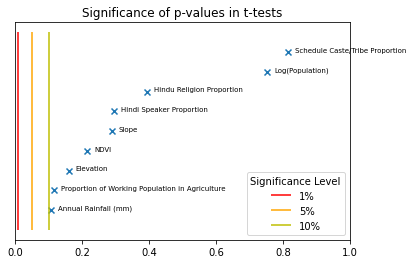

In [12]:
import matplotlib.pyplot as plt

p = ttest_val[['Variable', 'P-Value']].sort_values('P-Value').reset_index()
num = 0
for i in range(len(p)):
    num += 1
    p.loc[i, 'test'] = num

ticks = ['']

plt.scatter(p['P-Value'], p['test'], marker='x', label='_nolegend_')
plt.title('Significance of p-values in t-tests')
plt.yticks([])
plt.xlim([0,1.0])
plt.vlines(x=0.01, ymin=0, ymax=10, colors='r')
plt.vlines(x=0.05, ymin=0, ymax=10, colors='orange')
plt.vlines(x=0.1, ymin=0, ymax=10, colors='y')
plt.legend(['1%', '5%', '10%'],
            loc = 'lower right', title = 'Significance Level')

for i, label in enumerate(p['Variable']):
    plt.annotate(label, (p.loc[i, 'P-Value']+0.02, p.loc[i, 'test']), fontsize='x-small')

plt.show()


The table and chart above show that there do not appear to any significant differences in means between the two groups for any of the covariates. All significance levels are above 10%. This helps to show that the covariates are balanced.


Another way to check for balance among these covariates is to run multiple linear regressions with the covariate as the dependent variable. The regressions have the form:

 $$\begin{equation*} Covariate = \alpha + \beta_1 * DistancetoBorder + \beta_2 * British + Coordinates + \sum BorderFE + \epsilon \end{equation*}$$

 <img src="https://render.githubusercontent.com/render/math?math=Covariate = \alpha + \beta_1 * DistancetoBorder + \beta_2 * British + Coordinates + \sum BorderFE + \epsilon">

*Covariate* refers to the demographic or environmental characteristic. *DistancetoBorder* is the distance in meters to the closest treatment border, with negative values being used for British subdistricts. *British* is the dummy variable, which takes the value 1 if the subdistrict is formerly a British province. *Coordinates* and *BorderFE* are controls. *Coordinates* are simply each subdistrict's latitude and longitude values. *Σ BorderFE* refers to something called border fixed effects. As mentioned before, I have split the borders into different 150-mile segments. These border fixed effects are binary variables that equal 1 if a subdistrict is closest to that specific border segment and 0 otherwise. Border fixed effects ensure that the model is comparing subdistricts which are located near the same border segment, which means the subdistricts are close to one another geographically.

If the coefficient for the British dummy is insignificant for these regressions, this means that there does not seem to be a difference among the covariates between the British subdistricts and the princely ones. This would provide more evidence that the covariates are balanced. 

In [13]:
import statsmodels.api as sm

balance = km_50.copy().rename(columns={'log_pop': 'Log(Population)',
                                         'pop_dens': 'Population Density',
                                         'agr_worker_prop': 'Proportion of Working Population in Agriculture',
                                         'ST_SC_prop': 'Schedule Caste/Tribe Proportion',
                                         'Hindus_prop': 'Hindu Religion Proportion',
                                         'Hindis_prop': 'Hindi Speaker Proportion',
                                         'Elev': 'Elevation',
                                         'Rain': 'Annual Rainfall (mm)'})
balance.loc[balance['britdum'] == 1, 'Distance'] = balance.loc[balance['britdum'] == 1, 
                                                                'Distance'] * -1

covariates = ['Log(Population)', 
              'Schedule Caste/Tribe Proportion', 'Hindu Religion Proportion',
              'Proportion of Working Population in Agriculture',
              'Hindi Speaker Proportion', 'Elevation', 'Slope', 'Annual Rainfall (mm)',
              'NDVI']

dummies = pd.get_dummies(balance['Border'])
for i in range(dummies.shape[1]):
    dummies['Border' + str(i)] = dummies.iloc[:, i]
dummies = dummies.loc[:, dummies.columns.str.startswith('Border')]

balance = pd.concat([balance, dummies], axis=1)
coordinates = ['POINT_X', 'POINT_Y']
borders = []
for i in range(1, len(balance['Border'].unique()) - 1):
    step = 'Border' + str(i)
    borders.append(step)
regressor = ['Distance', 'britdum']

X_var = regressor + coordinates + borders
X = balance[X_var]
X = sm.add_constant(X)

pval = []
X.isna()
for cov in covariates:
    y = balance[cov]
    y = y.astype(float)
    model = sm.OLS(y, X)
    results = model.fit()
    p = results.pvalues[2]
    coef = results.params[2]
    vals = [cov, coef, p]
    pval.append(vals)

residual = pd.DataFrame(pval, columns = ['Variable', 'Coefficient for British Dummy', 'P-Value'])

def color_sig(val):
    if val <= 0.01:
        color = 'red'
    elif (val > 0.01) & (val <= 0.05):
        color = 'orange'
    elif (val > 0.05) & (val < 0.1):
        color = 'yellow'
    else:
        color = ''
    return 'background-color: %s' % color

residual_result = residual.sort_values('P-Value')
residual_result['Significance'] = residual_result['P-Value'].apply(significance)

residual_result

,Variable,Coefficient for British Dummy,P-Value,Significance
3,Proportion of Working Population in Agriculture,-0.063720,0.001196,Strongly Significant
5,Elevation,-36.763625,0.120020,None
7,Annual Rainfall (mm),45.602191,0.243068,None
2,Hindu Religion Proportion,-0.009597,0.293080,None
0,Log(Population),-0.063386,0.349298,None
8,NDVI,0.002099,0.707144,None
4,Hindi Speaker Proportion,-0.002745,0.768602,None
1,Schedule Caste/Tribe Proportion,-0.003975,0.826170,None
6,Slope,0.014419,0.966651,None


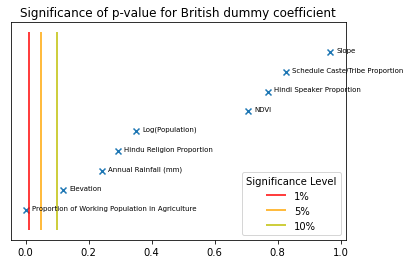

In [14]:
import matplotlib.pyplot as plt

p = residual[['Variable', 'P-Value']].sort_values('P-Value').reset_index()
num = 0
for i in range(len(p)):
    num += 1
    p.loc[i, 'test'] = num

plt.scatter(p['P-Value'], p['test'], marker='x', label='_nolegend_')
plt.title('Significance of p-value for British dummy coefficient')
plt.yticks([])
plt.vlines(x=0.01, ymin=0, ymax=10, colors='r')
plt.vlines(x=0.05, ymin=0, ymax=10, colors='orange')
plt.vlines(x=0.1, ymin=0, ymax=10, colors='y')
plt.legend(['1%', '5%', '10%'],
            loc = 'lower right', title = 'Significance Level')

for i, label in enumerate(p['Variable']):
    plt.annotate(label, (p.loc[i, 'P-Value']+0.02, p.loc[i, 'test']), fontsize='x-small')

plt.show()

As the table and chart above show, the coefficient for the British dummy is negative and strongly significant. British subdistricts seem to have a lower proportion of its population working in agriculture. While this result does not immediately ruin the assumption of balanced covariates, it is worrying. 

For a more in-depth research project, I would go deeper to investigate this issue. I would have to determine if this fact could skew the results of my model. However, since this is a personal project, I simply acknowledge the existence of this potential issue and continue on with the rest of my project.

## Model Estimation And Results

The model that I created to estimate the treatment effect of being a former British province is:

 $$ y_i = \alpha + \beta British_i + f(geographic \ location_i) + \sum BorderFE_i + X_i + \epsilon $$

$y_i$ is the outcome variable, which is the living standard variables or the public good variables. $British_i$ is the treatment, denoted by the British dummy. $X_i$ are control variables. These controls are the same environmental and demographic covariates that were tested for balance above. $f(geographic \ location_i)$ is a cubic polynomial constructed from the subdistrict's latitudinal and longitudinal coordinates. This polynomial controls for smooth functions of geographic location. Finally, $\sum BorderFE_i$ are the border segment fixed effects that were also described before. Again, these fixed effects ensure that subdistricts are compared to other subdistricts that are geographically close.

I have also clustered my standard errors at the district level. This is to account for any unobserved similarities between subdistricts which are located in the same district.

In [15]:
km_50['x2'] = np.power(km_50['POINT_X'], 2)
km_50['x3'] = np.power(km_50['POINT_X'], 3)
km_50['y2'] = np.power(km_50['POINT_Y'], 2)
km_50['y3'] = np.power(km_50['POINT_X'], 3)
km_50['xy'] = km_50['POINT_X'] * km_50['POINT_Y']
km_50['x2y'] = km_50['x2'] * km_50['POINT_Y']
km_50['xy2'] = km_50['POINT_X'] * km_50['y2']

dummies = pd.get_dummies(km_50['Border'])
for i in range(dummies.shape[1]):
    dummies['Border' + str(i)] = dummies.iloc[:, i]
dummies = dummies.loc[:, dummies.columns.str.startswith('Border')]

km_50 = pd.concat([km_50, dummies], axis=1)


In [16]:
livelihood = ['Radio_Prop', 'Television_Prop', 'Car_Prop', 'Bathroom_Prop', 
              'FlushToilet_Prop', 'TapWater_Prop', 'Electricity_Prop',
              'MudFloor_Prop']
public_goods = ['PrimarySchool_Prop', 'MiddleSchool_Prop', 'SecondarySchool_Prop',
                'PrimaryHealthCenter_Prop', 'PostOffice_Prop', 'Phone_Prop']
controls = ['Elev', 'Rain', 'Slope', 'NDVI', 'agr_worker_prop', 'ST_SC_prop',
            'Hindis_prop', 'Hindus_prop', 'log_pop'] 
coordinates = ['POINT_X', 'POINT_Y', 'xy', 'x2', 'y2', 'x2y', 'xy2', 'x3', 'y3']
borders = []
for i in range(0, len(km_50['Border'].unique()) - 1):
    step = 'Border' + str(i)
    borders.append(step)

regressor = ['britdum']

X_var = regressor + controls + coordinates + borders
X = km_50[X_var]
X = sm.add_constant(X)

model_results = []

for var in livelihood:
    y = km_50[var]
    model = sm.OLS(y.astype(float), X.astype(float), cov_type='cluster', groups=km_50['Code_StateDist'])
    results = model.fit()
    variable = var
    coef = results.params[1]
    std_err = results.bse[1]
    t = results.tvalues[1]
    p = results.pvalues[1]
    vals = [var, coef, std_err, t, p]
    model_results.append(vals)
ls_result = pd.DataFrame(model_results, columns = ['Variable', 'Coefficient for British Dummy',
                                                   'Standard Error', 'T-Value', 'P-Value'])
    
ls_result['Significance'] = ls_result['P-Value'].apply(significance)
ls_result

,Variable,Coefficient for British Dummy,Standard Error,T-Value,P-Value,Significance
0,Radio_Prop,0.015864,0.003869,4.100208,0.000046,Strongly Significant
1,Television_Prop,0.005384,0.005299,1.015996,0.309961,None
2,Car_Prop,-0.000303,0.000642,-0.472292,0.636856,None
3,Bathroom_Prop,-0.000742,0.006947,-0.106840,0.914944,None
4,FlushToilet_Prop,0.003858,0.004826,0.799518,0.424245,None
5,TapWater_Prop,0.016953,0.011053,1.533728,0.125521,None
6,Electricity_Prop,-0.000973,0.007703,-0.126325,0.899509,None
7,MudFloor_Prop,-0.020189,0.008076,-2.499932,0.012635,Significant


These results indicate that households in the British subdistricts are more likely to own a radio, and this result is strongly significant. Furthermore, the British subdistricts are also less likely to have a mud floor, and this result is significant. In contrast to Iyer's hypothesis, these results indicate that the subdistricts which were located in British provinces have better living standards than the princely state subdistricts. These subdistricts are more likely to own a radio, and they are more likely to have a floor made of wood, cement, etc., rather than a floor made of mud. 

In [17]:
model_results = []

for var in public_goods:
    y = km_50[var]
    model = sm.OLS(y.astype(float), X.astype(float), cov_type='cluster', groups=km_50['Code_StateDist'])
    results = model.fit()
    variable = var
    coef = results.params[1]
    std_err = results.bse[1]
    t = results.tvalues[1]
    p = results.pvalues[1]
    vals = [var, coef, std_err, t, p]
    model_results.append(vals)

pg_result = pd.DataFrame(model_results, columns =['Variable', 'Coefficient for British Dummy',
                                                  'Standard Error','T-Value', 'P-Value'])
pg_result['Significance'] = pg_result['P-Value'].apply(significance)

pg_result

,Variable,Coefficient for British Dummy,Standard Error,T-Value,P-Value,Significance
0,PrimarySchool_Prop,-0.710618,0.213713,-3.325100,0.000927,Strongly Significant
1,MiddleSchool_Prop,-0.334986,0.105621,-3.171581,0.001578,Strongly Significant
2,SecondarySchool_Prop,-0.070846,0.051774,-1.368372,0.171607,None
3,PrimaryHealthCenter_Prop,0.027162,0.015618,1.739159,0.082419,Weakly Significant
4,PostOffice_Prop,0.077699,0.062886,1.235549,0.217015,None
5,Phone_Prop,-0.164652,2.838571,-0.058005,0.953760,None


The results for the public goods' variables are more in line with Iyer's hypothesis. The British province subdistricts have a lower number of primary schools (elementary schools) and middle schools per capita. These results are strongly significant. The British province subdistricts show some evidence of having more primary health centers per capita; however, this result is only weakly significant.

In the end, the model results seem to be conflicting. Princely subdistricts do seem to have more schools and potentially more health centers than British subdistricts. This fact does line up with Iyer's hypothesis, and it actually mirrors the results Iyer obtained in her study. Schools and health centers are public goods that are often built by the government. If a local ruler in a princely state cared more about investing in the area than a British governor, it would make sense that these princely subdistricts have more schools and health centers today than the British subdistricts. Yet, the results for the living standard variables show that the princely subdistricts are not enjoying greater economic well-being than the British subdistrits. In fact, the results indicate that the British subdistricts might be better off. Thus, this higher availability of public goods in the princely subdistricts does not seem to have led to a long-term benefit in economic well-being over the British subdistricts.